Author: Yihao Liu yliu333@jhu.edu

In [ ]:
import io
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import vot

# 1.0 Data Labelling 

## 1.1 Network Design

## 1.2 Data Labelling

# 2.0 Inference

## 2.1 Inference Model Design (Modify Unet to be a RNN-Unet. )

### 2.1.1 First I copy HW6 content to here as backbone

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())

import torch.nn.functional as F
# U-Net
class UNET(nn.Module):

    def __init__(self, useBN=True):
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight.data)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)
        return conv1m_out

### 2.1.2 Then, write the in/out concat to support multi-input. Also write RNN base module and RNN architecture.

In [ ]:
# UNET-RNN

class OutConcat(nn.Module):

    def __init__(self,n_classes, useBN=True):
        super(OutConcat, self).__init__()
        self.mergeconv = add_conv_stage(34, 32)
        self.outl = nn.Conv2d(32,n_classes,1) # pixel-wise, so kernel is 1
        self.outll = nn.ReLU()
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight.data)

    def forward(self, x, preout):
        out = torch.cat((x, preout),dim=1)  
        # dim=1 because cat in channel, not batch
        out = self.mergeconv(out)
        out = self.outll(self.outl(out))
        return out

class InConcat(nn.Module):

    def __init__(self, useBN=True):
        super(InConcat, self).__init__()
        self.mergeconv = add_conv_stage(6, 32)
        self.conv = add_conv_stage(32, 3)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight.data)

    def forward(self, x, prein):
        out = torch.cat((x, prein),dim=1)  
        # dim=1 because cat in channel, not batch
        out = self.mergeconv(out)
        out = self.conv(out)
        return out

class RNNBase(nn.Module):

    def __init__(self):
        super(RNNBase, self).__init__()
        self.inmod = InConcat()
        self.outmod = OutConcat(2) # n_classes = 2 (binary seg)
        self.unet = UNET()
    
    def forward(self, hidden, curin):
        prein, preout = hidden
        out = self.inmod(curin, prein)
        out = self.unet(out)
        out = self.outmod(out, preout)
        return (curin, out) # hidden layer as a tuple of prein and preout

# TODO: modify by pytorch convention
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
# TODO: currently, it seems only dependent on previous, aka, no ancient memory.
# Do something like LSTM?

### 2.1.3 Modify the RNN-Unet to be LSTM-Unet

In [ ]:
class LSTMBase(nn.Module):

    def __init__(self):
        super(LSTMBase, self).__init__()
        self.rnn = RNNBase()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, hidden, curin):
        long_hidden, short_hidden = hidden
        _, hx = self.rnn(short_hidden, curin)
        gate_in = self.sigmoid(hx)
        gate_forget = self.sigmoid(hx)
        gate_cell = self.tanh(hx)
        gate_out = self.sigmoid(hx)
        long_hidden = (gate_forget * long_hidden) + (gate_in * gate_cell)
        short_hidden = (curin, gate_out * self.tanh(long_hidden))
        return (long_hidden, short_hidden) # short_hidden[1] is also out



Loss

## 2.2 Training

## 2.3 Plots, Validation, Others

# 1.0 Data Processing (RNN-Unet)

In [ ]:
import io
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import skimage
import vot
from vot import region

19945 19945


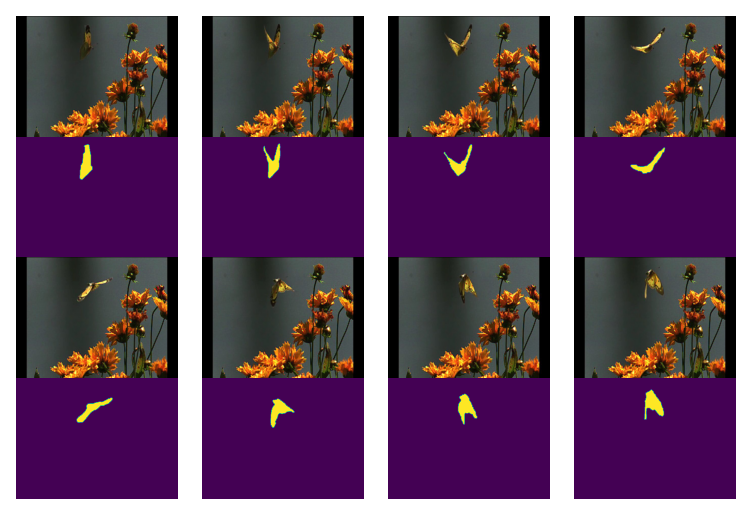

In [ ]:
VIDEO_DATA_PATH = 'data/vot2020/sequences'
data_folders = os.walk(VIDEO_DATA_PATH)
data_segments = next(data_folders)[1]

# print(data_segments)
data_videos = []

for i in data_segments:
    data_videos.append(os.path.join(VIDEO_DATA_PATH,i,'color'))

data_frames = []
data_masks = []
for i in data_videos:
    cur_sequence_len = len(os.listdir(i))
    # print(cur_sequence_len)
    for j in range(2000):
        cur = os.path.join(i,(str(j+1).zfill(8)+'.jpg'))
        # print(cur)
        if os.path.exists(cur):
            data_frames.append(cur)
            data_masks.append([os.path.join(i[:-6],'groundtruth.txt'),j+1,cur_sequence_len])
            # data_masks: path, idx, num_frames_in_sequence
        else:
            # data_frames.append(1) # use as separator for different sequences
            # data_masks.append(1)
            break

print(len(data_frames),len(data_masks)) #19945 images + 60 separators
# print(data_masks)


class VOTDataset(Dataset):

    def __init__(self, data_frames, data_masks, op, transforms):
        sep_idx = (int) (len(data_frames) * 0.8)
        while data_masks[sep_idx][2] != data_masks[sep_idx][1]:
            sep_idx+=1
        sep_idx+=1
        sep_idx_2 = sep_idx
        while data_masks[sep_idx_2-1][1] != 1:
            sep_idx_2-=1
        sep_idx_2-=1
        try:
            if op == 'train':
                self.data_frames = data_frames[:sep_idx]
                self.data_masks = data_masks[:sep_idx]
            elif op == 'test':
                self.data_frames = data_frames[sep_idx:]
                self.data_masks = data_masks[sep_idx:]
            elif op == 'val':
                self.data_frames = data_frames[sep_idx_2:sep_idx]
                self.data_masks = data_masks[sep_idx_2:sep_idx]
        except ValueError:
            print('op should be either train or test!')
        self.transform = transforms

    def __len__(self):
        return len(self.data_frames)

    def __getitem__(self, idx):
        img = skimage.io.imread(self.data_frames[idx])
        h, w, c = img.shape
        # print(self.data_frames[idx])
        mask = self.get_mask_from_iiiii(idx,h,w)
        cur_frame = self.data_masks[idx][1]
        seq_len = self.data_masks[idx][2]
        
        img, mask = self.img_transform(img, mask)
        return img, mask, cur_frame, seq_len

    def img_transform(self, img, mask):
        img = self.transform(img)
        mask = self.transform(mask)
        
        return img, mask

    def get_mask_from_iiiii(self, idx,h,w):
        data_mask = self.data_masks[idx]
        cur_idx = data_mask[1]
        # print(data_mask[0])
        # print(cur_idx)
        with open(data_mask[0]) as fp:
            for i, line in enumerate(fp):
                # print(i)
                if i == cur_idx-1:
                    text_get = line
                    break
        text_get_ = text_get.split(",")

        vot_format = region.io.parse_region(text_get)
        mask_ = vot_format._mask
        # offset_ = vot_format._offset
        # print(offset_)
        
        mask_1 = np.ones((h, w, 1))
        mask_2 = np.zeros((h, w, 1))
        mask = np.concatenate((mask_1, mask_2), axis=2)
        # print(mask_.shape, mask.shape)

        base_x = int(text_get_[0][1:])
        base_y = int(text_get_[1])
        for i in range(mask_.shape[0]):
            for j in range(mask_.shape[1]):
                if mask_[i][j] > 0:
                    mask[base_y+i][base_x+j][1] = 1 
                    mask[base_y+i][base_x+j][0] = 0

        return mask

img_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize((360,360))
])

train_dataset = VOTDataset(data_frames, data_masks, op='train', transforms=img_transform)
test_dataset = VOTDataset(data_frames, data_masks, op='test', transforms=img_transform)
val_dataset = VOTDataset(data_frames, data_masks, op='val', transforms=img_transform)

img, mask, cur_frame, seq_len = train_dataset[11000+8]
img1, mask1, cur_frame, seq_len = train_dataset[11000+9]
img2, mask2, cur_frame, seq_len = train_dataset[11000+10]
img3, mask3, cur_frame, seq_len = train_dataset[11000+11]
img4, mask4, cur_frame, seq_len = train_dataset[11000+12]
img5, mask5, cur_frame, seq_len = train_dataset[11000+13]
img6, mask6, cur_frame, seq_len = train_dataset[11000+14]
img7, mask7, cur_frame, seq_len = train_dataset[11000+15]

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4)
axs[0, 0].imshow(  img.permute(1, 2, 0) )
axs[0, 0].axis('off')
axs[1, 0].imshow(  mask[1,:,:] )
axs[1, 0].axis('off')
axs[0, 1].imshow(  img1.permute(1, 2, 0) )
axs[0, 1].axis('off')
axs[1, 1].imshow(  mask1[1,:,:] )
axs[1, 1].axis('off')
axs[0, 2].imshow(  img2.permute(1, 2, 0) )
axs[0, 2].axis('off')
axs[1, 2].imshow(  mask2[1,:,:] )
axs[1, 2].axis('off')
axs[0, 3].imshow(  img3.permute(1, 2, 0) )
axs[0, 3].axis('off')
axs[1, 3].imshow(  mask3[1,:,:] )
axs[1, 3].axis('off')
axs[2, 0].imshow(  img4.permute(1, 2, 0) )
axs[2, 0].axis('off')
axs[3, 0].imshow(  mask4[1,:,:] )
axs[3, 0].axis('off')
axs[2, 1].imshow(  img5.permute(1, 2, 0) )
axs[2, 1].axis('off')
axs[3, 1].imshow(  mask5[1,:,:] )
axs[3, 1].axis('off')
axs[2, 2].imshow(  img6.permute(1, 2, 0) )
axs[2, 2].axis('off')
axs[3, 2].imshow(  mask6[1,:,:] )
axs[3, 2].axis('off')
axs[2, 3].imshow(  img7.permute(1, 2, 0) )
axs[2, 3].axis('off')
axs[3, 3].imshow(  mask7[1,:,:] )
axs[3, 3].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig.set_dpi(160)
# img, mask, cur_frame, seq_len = val_dataset[0]
# print(len(val_dataset))



In [ ]:
# print((int)(len(data_frames) * 0.8))
# sep_idx = (int) (len(data_frames) * 0.8)
# print(data_masks[sep_idx][2],data_masks[sep_idx][1])
# while data_masks[sep_idx][2] != data_masks[sep_idx][1]:
#     sep_idx+=1
#     # print(data_masks[sep_idx][2],data_masks[sep_idx][1])
# print(sep_idx)
# print(data_frames[11000])

In [ ]:
def dice_score_image(prediction, target, n_classes): # Only works if batch size is 1

    dice_classes = np.zeros(n_classes)

    new_mask = torch.zeros(n_classes, prediction.size(dim=0), prediction.size(dim=1)).cuda()
    for idx in range(n_classes):
        new_mask[idx, :, :] = prediction == idx
    for cl in range(n_classes):
        TP = torch.sum((new_mask[cl, :, :].reshape(-1) > 0) * (target[cl, :, :].reshape(-1) > 0))
        FP = torch.sum((new_mask[cl, :, :].reshape(-1) > 0) * (target[cl, :, :].reshape(-1) < 1))
        FN = torch.sum((new_mask[cl, :, :].reshape(-1) < 1) * (target[cl, :, :].reshape(-1) > 0))
        dice_classes[cl] = (2.0 * TP) / ((TP + FP) + (TP + FN))
        if torch.sum(target[cl, :, :].reshape(-1)==0):
            if FP == 0:
                dice_classes[cl] = 1.0
            if FP > 0:
                dice_classes[cl] = 0.0
    return dice_classes.mean()

def dice_score_dataset(model, dataloader):
    with torch.no_grad():
        ## Number of Batches and Cache over Dataset 
        n_batches = len(dataloader)
        # print(1,n_batches)
        scores = np.zeros(n_batches)
        ## Evaluate
        model.eval() # have eval in the training code
        idx = 0
        init_batch_val_score = 1
        for i, (img, mask, cur_frame, seq_len) in enumerate(dataloader):
            img, mask = \
                img.cuda().float(), \
                mask.cuda().float()
            if init_batch_val_score:
                pre_mask = mask
                pre_img = img
                long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
                init_batch_val_score = 0
            for cur_frame_i in range(len(cur_frame)):
                if cur_frame[cur_frame_i]==1:
                    pre_mask[cur_frame_i] = mask[cur_frame_i]
                    pre_img[cur_frame_i] = img[cur_frame_i]
                    long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
            
            (long_hidden, short_hidden) \
                = model((long_hidden, (pre_img, pre_mask)) , img)
          
            outputs = short_hidden[1]
            
            long_hidden = long_hidden
            pre_mask = short_hidden[1]
            pre_img = img

            n_classes = outputs.shape[1]
            prediction = torch.argmax(outputs, dim = 1)
            scores[idx] = dice_score_image(prediction[0,:,:], mask[0,:,:,:], n_classes) 
            idx += 1
            # print(outputs.shape)
            
        # Average Dice Score Over Images
        m_dice = scores.mean()
        return m_dice
    

class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__() 
    
    def forward(self, prediction, target):
        dice_coef_mean = 0
        for i in range(target.size(dim=2)):
            p = prediction[:,:,i].reshape(-1)
            t = target[:,:,i].reshape(-1)
            num = 2.0 * torch.sum( p * t )
            den = torch.sum(p * p) + torch.sum(t * t)
            dice_coef = num/den
            dice_coef_mean = dice_coef_mean + dice_coef
        dice_coef_mean = dice_coef_mean / target.size(dim=2)
        return 1 - dice_coef_mean

In [ ]:
n_classes = 2
# model = RNNBase().cuda()
model = LSTMBase().cuda()
loss = DICELoss().cuda()

# print(model)

learning_rate = 0.005
num_epochs = 10

batch_size=15

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_dataset_dicescore = VOTDataset(data_frames, data_masks, op='val', transforms=img_transform)
val_dataloader_dicescore = DataLoader(val_dataset_dicescore, batch_size=1, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

def val_eval(model, loss):
    with torch.no_grad():
        loss_sum = 0.0
        ctr = 0
        init_batch_val = 1
        for i, (img, mask, cur_frame, seq_len) in enumerate(val_dataloader):
            img, mask = \
                img.cuda().float(), \
                mask.cuda().float()
            if init_batch_val:
                pre_mask = mask
                pre_img = img
                long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
                init_batch_val = 0
            for cur_frame_i in range(len(cur_frame)):
                if cur_frame[cur_frame_i]==1:
                    pre_mask[cur_frame_i] = mask[cur_frame_i]
                    pre_img[cur_frame_i] = img[cur_frame_i]
                    long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
            try:
                (long_hidden, short_hidden) \
                    = model((long_hidden, (pre_img, pre_mask)) , img)
            except:
                pass
            outputs = short_hidden[1]
            try:
                loss_ = loss(outputs, mask)
            except:
                pass
            loss_sum = loss_sum + loss_.item()
            long_hidden = long_hidden
            pre_mask = short_hidden[1]
            pre_img = img
            ctr+=1
    return loss_sum / ctr

def test_eval(model, loss):
    with torch.no_grad():
        loss_sum = 0.0
        ctr = 0
        init_batch_test = 1
        for i, (img, mask, cur_frame, seq_len) in enumerate(test_dataloader):
            img, mask = \
                img.cuda().float(), \
                mask.cuda().float()
            if init_batch_test:
                pre_mask = mask
                pre_img = img
                long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
                init_batch_test = 0
            for cur_frame_i in range(len(cur_frame)):
                if cur_frame[cur_frame_i]==1:
                    pre_mask[cur_frame_i] = mask[cur_frame_i]
                    pre_img[cur_frame_i] = img[cur_frame_i]
                    long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
            try:
                (long_hidden, short_hidden) \
                    = model((long_hidden, (pre_img, pre_mask)) , img)
            except:
                pass
            outputs = short_hidden[1]
            try:
                loss_ = loss(outputs, mask)
            except:
                pass
            loss_sum = loss_sum + loss_.item()
            long_hidden = long_hidden
            pre_mask = short_hidden[1]
            pre_img = img
            ctr+=1
    return loss_sum / ctr

print("Start Training...")
# torch.autograd.set_detect_anomaly(True)
train_loss_arr, test_loss_arr, dice_val_arr, val_loss_arr = [], [], [], []

for epoch in range(num_epochs):

    model.eval()
    test_loss = test_eval(model, loss)
    print("Test loss: " + str(test_loss))
    test_loss_arr.append(test_loss)
    model.train()

    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    loss_sum = 0.0
    init_batch = 1
    for i, (img, mask, cur_frame, seq_len) in enumerate(train_dataloader):
        # print(cur_frame)
        img, mask = \
            img.cuda().float(), \
            mask.cuda().float()
        if i > 0 or epoch > 0:
            optimizer.zero_grad()

        if init_batch:
            pre_mask = mask
            pre_img = img
            long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
            init_batch = 0

        for cur_frame_i in range(len(cur_frame)):
            if cur_frame[cur_frame_i]==1:
                pre_mask[cur_frame_i] = mask[cur_frame_i]
                pre_img[cur_frame_i] = img[cur_frame_i]
                long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
        try:
            (long_hidden, short_hidden) \
                = model((long_hidden, (pre_img, pre_mask)) , img)
        except:
            pass
        outputs = short_hidden[1]
        try:
            loss_ = loss(outputs, mask)
        except:
            pass
        try:
            loss_.backward()
        except:
            pass
        optimizer.step()
        loss_sum = loss_sum + loss_.item()
        long_hidden = long_hidden
        pre_mask = short_hidden[1]
        pre_img = img
        if i%50==0:
            print("" + str(i) + "/" + str(20000/batch_size) )
            print("Train loss: " + str(loss_.item()))
            train_loss_arr.append(loss_.item())
        if i%200==0:
            init_batch = 1
            val_loss = val_eval(model, loss)
            print("Val loss: " + str(val_loss))
            val_loss_arr.append(val_loss)
            dice_score_val = dice_score_dataset(model, val_dataloader_dicescore)
            print("Val Dice ", dice_score_val)
            dice_val_arr.append(dice_score_val)


Start Training...
Test loss: 0.9635239767830401

EPOCH 1 of 10

0/1333.3333333333333
Train loss: 0.7250716090202332
Val loss: 0.608381660361039
Val Dice  0.0
50/1333.3333333333333
Train loss: 0.017837226390838623
100/1333.3333333333333
Train loss: 0.0177459716796875
150/1333.3333333333333
Train loss: 0.00855487585067749
200/1333.3333333333333
Train loss: 0.06835120916366577
Val loss: 0.02445509245521144
Val Dice  0.5
250/1333.3333333333333
Train loss: 0.014979124069213867
300/1333.3333333333333
Train loss: 0.013019084930419922
350/1333.3333333333333
Train loss: 0.002049684524536133
400/1333.3333333333333
Train loss: 0.0007372498512268066
Val loss: 0.02445462659785622
Val Dice  0.5
450/1333.3333333333333
Train loss: 0.006775498390197754
500/1333.3333333333333
Train loss: 0.007513999938964844
550/1333.3333333333333
Train loss: 0.022450506687164307
600/1333.3333333333333
Train loss: 0.0626174807548523
Val loss: 0.02445472227899652
Val Dice  0.5
650/1333.3333333333333
Train loss: 0.0013267

In [ ]:
print(outputs.shape, mask.shape)
torch.save(model, 'lstmunet2')

torch.Size([15, 2, 360, 360]) torch.Size([6, 2, 360, 360])


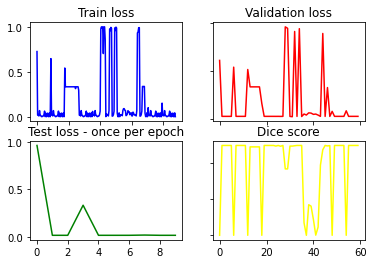

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(train_loss_arr, '-', color = 'blue')
axs[0, 0].set_title('Train loss')
axs[0, 1].plot(val_loss_arr, '-', color = 'red')
axs[0, 1].set_title('Validation loss')
axs[1, 0].plot(test_loss_arr, '-', color = 'green')
axs[1, 0].set_title('Test loss - once per epoch')
axs[1, 1].plot(dice_val_arr, '-', color = 'yellow')
axs[1, 1].set_title('Dice score')
for ax in axs.flat:
    ax.label_outer()
plt.show()


tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         ...,
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
          1.0000e+00, 1.0000e+00]],

        [[1.8185e-16, 2.7065e-16, 1.8161e-16,  ..., 3.8767e-16,
          9.6559e-17, 5.1686e-18],
         [2.1223e-16, 2.9567e-16, 1.8587e-16,  ..., 6.7799e-17,
          8.8343e-17, 2.1764e-16],
         [1.6132e-16, 4.2215e-16, 3.7051e-16,  ..., 1.0873e-16,
          4.3876e-16, 3.5496e-16],
         ...,
         [3.6568e-16, 1.5127e-16, 3.5783e-16,  ..., 2.1376e-16,
          3.525

(-0.5, 359.5, 359.5, -0.5)

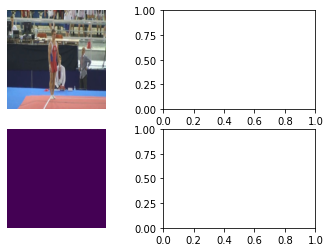

In [ ]:
def val_eval_mask(model):
    with torch.no_grad():
        loss_sum = 0.0
        ctr = 0
        init_batch_val = 1
        for i, (img, mask, cur_frame, seq_len) in enumerate(val_dataloader_dicescore):
            img, mask = \
                img.cuda().float(), \
                mask.cuda().float()
            if init_batch_val:
                pre_mask = mask
                pre_img = img
                long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
                init_batch_val = 0
            for cur_frame_i in range(len(cur_frame)):
                if cur_frame[cur_frame_i]==1:
                    pre_mask[cur_frame_i] = mask[cur_frame_i]
                    pre_img[cur_frame_i] = img[cur_frame_i]
                    long_hidden = torch.rand(img.shape[0], 2, 360, 360,dtype=torch.float).cuda().float()
            (long_hidden, short_hidden) \
                = model((long_hidden, (pre_img, pre_mask)) , img)

            outputs = short_hidden[1]
            
            long_hidden = long_hidden
            pre_mask = short_hidden[1]
            pre_img = img
            ctr+=1
            if ctr >=50:
                break
    return short_hidden[1], img

test_show_mask, img = val_eval_mask(model)
print(test_show_mask[0])
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(  img[0].cpu().permute(1, 2, 0) )
axs[0, 0].axis('off')
axs[1, 0].imshow(  test_show_mask[0].cpu()[0,:,:] )
axs[1, 0].axis('off')